<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: ;
           font-size:110%;
           letter-spacing:0.6px">

<h2 style="padding: 30px;
              color:snow;"> Practica 2: Sensado y análisis de video

</h2>
</div>

In [1]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
conda update --all

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/roxanarachel/anaconda3


The following packages will be UPDATED:

  blas-devel                     3.9.0-17_osxarm64_openblas --> 3.9.0-21_osxarm64_openblas 
  libblas                        3.9.0-17_osxarm64_openblas --> 3.9.0-21_osxarm64_openblas 
  libcblas                       3.9.0-17_osxarm64_openblas --> 3.9.0-21_osxarm64_openblas 
  libgfortran5       pkgs/main::libgfortran5-11.3.0-h00934~ --> conda-forge::libgfortran5-13.2.0-hf226fd6_3 
  liblapack                      3.9.0-17_osxarm64_openblas --> 3.9.0-21_osxarm64_openblas 
  liblapacke                     3.9.0-17_osxarm64_openblas --> 3.9.0-21_osxarm64_openblas 
  libopenblas                      0.3.23-openmp_hc731615_0 --> 0.3.26-openmp_h6c19121_0 
  openblas                         0.3.23-openmp_hf78f355_0 --> 0.3.26-openmp_h55c453e_0 

The following packages will be SUPERSEDED by a hi

In [6]:
import cv2
import os
import shutil
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt

# Segmentacion de videos

Se proporcionó un archivo CSV que contiene los detalles de segmentación para cada video, incluyendo el nombre del video, el tiempo de inicio y fin de cada PAV, y el nombre del clip. Este archivo sirvió como entrada para el proceso de segmentación.

In [7]:
# Ruta del directorio donde se encuentran los videos originales
videos_folder = "/Users/roxanarachel/Desktop/VideosCrudos"

# Directorio de salida para los clips segmentados
output_folder = "/Users/roxanarachel/Desktop/clips1"

# Leer el DataFrame con los detalles de segmentación desde el archivo CSV
df_points_file = "df_points1.1.csv"

# Verificar si el archivo CSV existe
if not os.path.exists(df_points_file):
    print(f"Error: El archivo {df_points_file} no existe.")
    exit()

# Leer el DataFrame con los detalles de segmentación desde el archivo CSV
df_points = pd.read_csv(df_points_file)

# Crear el directorio de salida si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Función para segmentar un video en clips
def segment_video(video_path, start_time, end_time, clip_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(clip_path, fourcc, fps, (width, height))
    while cap.isOpened():
        ret, frame = cap.read()
        if ret and cap.get(cv2.CAP_PROP_POS_FRAMES) <= end_frame:
            out.write(frame)
        else:
            break
    cap.release()
    out.release()

# Almacenamiento de archivos en subcarpetas

Se realizaron segmentaciones específicas para cada uno de los cinco PAV definidos, garantizando una adecuada organización y análisis de los datos recolectados.

In [8]:
# Función para convertir el tiempo en formato HH:MM:SS a segundos
def time_to_seconds(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds

# Iterar sobre cada fila del DataFrame para segmentar los videos y organizar los clips
for _, row in df_points.iterrows():
    video_name = row["video_name"]
    start_time = row["start_time"]
    end_time = row["end_time"]
    clip_name = row["clip_name"]
    punto_atencion = row["punto_atencion"]
    
    # Ruta completa del video original
    video_path = os.path.join(videos_folder, video_name)
    
    # Verificar si el video original existe
    if not os.path.exists(video_path):
        print(f"El video {video_name} no se encuentra en el directorio especificado.")
        continue
    
    # Convertir los tiempos de inicio y fin a segundos
    start_seconds = time_to_seconds(start_time)
    end_seconds = time_to_seconds(end_time)
    
    # Ruta del directorio de salida para el punto de atención visual
    punto_atencion_folder = os.path.join(output_folder, punto_atencion)
    
    # Crear el directorio de salida para el punto de atención visual si no existe
    if not os.path.exists(punto_atencion_folder):
        os.makedirs(punto_atencion_folder)
    
    # Ruta completa del clip segmentado
    clip_path = os.path.join(punto_atencion_folder, clip_name)
    
    # Segmentar el video
    segment_video(video_path, start_seconds, end_seconds, clip_path)

print("Segmentación completa.")

Segmentación completa.


# Detección de puntos en todos los videos de las subcarpetas

Durante esta fase, se implementó el proceso de detección de puntos en la cara utilizando la tecnología de FaceDetection en los clips de video segmentados. Esta tarea se llevó a cabo con el objetivo de identificar y registrar los puntos clave en la cara de los conductores en cada segmento de video.

In [9]:
# Ruta al directorio con las subcarpetas de videos segmentados
directory_path = '/Users/roxanarachel/Desktop/clips1'

# Inicializar el modelo de detección de rostros de MediaPipe
face_detection = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Iterar sobre las subcarpetas
for root, dirs, files in os.walk(directory_path):
    # Iterar sobre los archivos en la subcarpeta actual
    for file in files:
        # Verificar si el archivo es un video
        if file.endswith(".mp4"):
            # Ruta al video
            video_path = os.path.join(root, file)

            # Abrir el video
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                print(f"Error al abrir el video: {video_path}")
                continue

            #print(f"Procesando video: {video_path}")

            while True:
                success, image = cap.read()
                if not success:
                    print("Fin del video.")  # Indica el fin del video y sale del bucle
                    break

                # Convertir la imagen a RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False

                # Procesar la imagen con la detección de rostros
                results = face_detection.process(image)

                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                # Dibujar los resultados de la detección
                if results.detections:
                    for detection in results.detections:
                        mp.solutions.drawing_utils.draw_detection(image, detection)
                        #print(detection)
                
                # Mostrar la imagen
                #cv2.imshow('Face Detection in Video', image)

                # Permite la opción de terminar prematuramente con la tecla 'q'
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            # Liberar los recursos y cerrar las ventanas
            cap.release()
            cv2.destroyAllWindows()


I0000 00:00:1707875391.463339       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.


# Detección de Keypoints de una sola imagen 

## Recolección de Keypoints de todas las clases

En esta parte se llevó a cabo la detección de keypoints en una sola imagen de cada segmentación de los clips contenidos en las respectivas carpetas. Este proceso se realizó con el objetivo de verificar y confirmar la precisión de los puntos detectados en los puntos de atención visual (PAV) indicados, lo que permitió obtener las coordenadas de cada uno de los puntos clave.

In [13]:
import cv2
import mediapipe as mp
import pandas as pd

# Ruta al primer video
video_path_1 = '/Users/roxanarachel/Desktop/clips1/frente/clip_1a.mp4'

# Segundo específico que deseas procesar en el primer video
segundo_especifico_1 = 1 

# Número de imágenes que deseas procesar en el primer video
num_imagenes_1 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el primer video
face_detection_1 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el primer video
keypoints_list_1 = []

# Abrir el primer video
cap_1 = cv2.VideoCapture(video_path_1)

if not cap_1.isOpened():
    print(f"Error al abrir el video: {video_path_1}")
else:
    print(f"Procesando video: {video_path_1}")

    # Ir al segundo específico en el primer video
    cap_1.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_1 * 1000)

    contador_imagenes_1 = 0

    while True:
        success, image = cap_1.read()
        if not success or contador_imagenes_1 == num_imagenes_1:
            print("Fin del procesamiento del primer video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_1.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_1a.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_1.append(keypoints_data)

        contador_imagenes_1 += 1

    cap_1.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_2 = '/Users/roxanarachel/Desktop/clips1/frente/clip_1an.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_2 = 3  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_2 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_2 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_2 = []

# Abrir el segundo video
cap_2 = cv2.VideoCapture(video_path_2)

if not cap_2.isOpened():
    print(f"Error al abrir el video: {video_path_2}")
else:
    print(f"Procesando video: {video_path_2}")

    # Ir al segundo específico en el segundo video
    cap_2.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_2 * 1000)

    contador_imagenes_2 = 0

    while True:
        success, image = cap_2.read()
        if not success or contador_imagenes_2 == num_imagenes_2:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_2.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_1an.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_2.append(keypoints_data)

        contador_imagenes_2 += 1

    cap_2.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_3 = '/Users/roxanarachel/Desktop/clips1/frente/clip_1d.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_3 = 5  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_3 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_3 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_3 = []

# Abrir el segundo video
cap_3 = cv2.VideoCapture(video_path_3)

if not cap_3.isOpened():
    print(f"Error al abrir el video: {video_path_3}")
else:
    print(f"Procesando video: {video_path_3}")

    # Ir al segundo específico en el segundo video
    cap_3.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_3 * 1000)

    contador_imagenes_3 = 0

    while True:
        success, image = cap_3.read()
        if not success or contador_imagenes_3 == num_imagenes_3:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_3.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_1d.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_3.append(keypoints_data)

        contador_imagenes_3 += 1

    cap_3.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_4 = '/Users/roxanarachel/Desktop/clips1/frente/clip_1j.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_4 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_4 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_4 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_4 = []

# Abrir el segundo video
cap_4 = cv2.VideoCapture(video_path_4)

if not cap_4.isOpened():
    print(f"Error al abrir el video: {video_path_4}")
else:
    print(f"Procesando video: {video_path_4}")

    # Ir al segundo específico en el segundo video
    cap_4.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_4 * 1000)

    contador_imagenes_4 = 0

    while True:
        success, image = cap_4.read()
        if not success or contador_imagenes_4 == num_imagenes_4:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_4.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_1j.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_4.append(keypoints_data)

        contador_imagenes_4 += 1

    cap_4.release()
    cv2.destroyAllWindows()
    
# Ruta al segundo video
video_path_5 = '/Users/roxanarachel/Desktop/clips1/frente/clip_1r.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_5 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_5 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_5 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_5 = []

# Abrir el segundo video
cap_5 = cv2.VideoCapture(video_path_5)

if not cap_5.isOpened():
    print(f"Error al abrir el video: {video_path_5}")
else:
    print(f"Procesando video: {video_path_5}")

    # Ir al segundo específico en el segundo video
    cap_5.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_5 * 1000)

    contador_imagenes_5 = 0

    while True:
        success, image = cap_5.read()
        if not success or contador_imagenes_5 == num_imagenes_5:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_5.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_1r.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_5.append(keypoints_data)

        contador_imagenes_5 += 1

    cap_5.release()
    cv2.destroyAllWindows()
    
# Ruta al segundo video
video_path_6 = '/Users/roxanarachel/Desktop/clips1/frente/clip_1s.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_6 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_6 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_6 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_6 = []

# Abrir el segundo video
cap_6 = cv2.VideoCapture(video_path_6)

if not cap_6.isOpened():
    print(f"Error al abrir el video: {video_path_6}")
else:
    print(f"Procesando video: {video_path_6}")

    # Ir al segundo específico en el segundo video
    cap_6.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_6 * 1000)

    contador_imagenes_6 = 0

    while True:
        success, image = cap_6.read()
        if not success or contador_imagenes_6 == num_imagenes_6:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_6.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_1s.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_6.append(keypoints_data)

        contador_imagenes_6 += 1

    cap_6.release()
    cv2.destroyAllWindows()


# Ruta al segundo video
video_path_7 = '/Users/roxanarachel/Desktop/clips1/izquierda/clip_2a.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_7 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_7 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_7 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_7 = []

# Abrir el segundo video
cap_7 = cv2.VideoCapture(video_path_7)

if not cap_7.isOpened():
    print(f"Error al abrir el video: {video_path_7}")
else:
    print(f"Procesando video: {video_path_7}")

    # Ir al segundo específico en el segundo video
    cap_7.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_7 * 1000)

    contador_imagenes_7 = 0

    while True:
        success, image = cap_7.read()
        if not success or contador_imagenes_7 == num_imagenes_7:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_7.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_2a.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_7.append(keypoints_data)

        contador_imagenes_7 += 1

    cap_7.release()
    cv2.destroyAllWindows()
    
# Ruta al segundo video
video_path_8 = '/Users/roxanarachel/Desktop/clips1/izquierda/clip_2an.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_8 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_8 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_8 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_8 = []

# Abrir el segundo video
cap_8 = cv2.VideoCapture(video_path_8)

if not cap_8.isOpened():
    print(f"Error al abrir el video: {video_path_8}")
else:
    print(f"Procesando video: {video_path_8}")

    # Ir al segundo específico en el segundo video
    cap_8.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_8 * 1000)

    contador_imagenes_8 = 0

    while True:
        success, image = cap_8.read()
        if not success or contador_imagenes_8 == num_imagenes_8:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_8.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_2an.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_8.append(keypoints_data)

        contador_imagenes_8 += 1

    cap_8.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_9 = '/Users/roxanarachel/Desktop/clips1/izquierda/clip_2d.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_9 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_9 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_9 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_9 = []

# Abrir el segundo video
cap_9 = cv2.VideoCapture(video_path_9)

if not cap_9.isOpened():
    print(f"Error al abrir el video: {video_path_9}")
else:
    print(f"Procesando video: {video_path_9}")

    # Ir al segundo específico en el segundo video
    cap_9.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_9 * 1000)

    contador_imagenes_9 = 0

    while True:
        success, image = cap_9.read()
        if not success or contador_imagenes_9 == num_imagenes_9:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_9.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_2d.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_9.append(keypoints_data)

        contador_imagenes_9 += 1

    cap_9.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_10 = '/Users/roxanarachel/Desktop/clips1/izquierda/clip_2j.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_10 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_10 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_10 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_10 = []

# Abrir el segundo video
cap_10 = cv2.VideoCapture(video_path_10)

if not cap_10.isOpened():
    print(f"Error al abrir el video: {video_path_10}")
else:
    print(f"Procesando video: {video_path_10}")

    # Ir al segundo específico en el segundo video
    cap_10.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_10 * 1000)

    contador_imagenes_10 = 0

    while True:
        success, image = cap_10.read()
        if not success or contador_imagenes_10 == num_imagenes_10:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_10.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_2j.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_10.append(keypoints_data)

        contador_imagenes_10 += 1

    cap_10.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_11 = '/Users/roxanarachel/Desktop/clips1/izquierda/clip_2r.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_11 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_11 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_11 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_11 = []

# Abrir el segundo video
cap_11 = cv2.VideoCapture(video_path_11)

if not cap_11.isOpened():
    print(f"Error al abrir el video: {video_path_11}")
else:
    print(f"Procesando video: {video_path_11}")

    # Ir al segundo específico en el segundo video
    cap_11.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_11 * 1000)

    contador_imagenes_11 = 0

    while True:
        success, image = cap_11.read()
        if not success or contador_imagenes_11 == num_imagenes_11:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_11.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_2r.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_11.append(keypoints_data)

        contador_imagenes_11 += 1

    cap_11.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_12 = '/Users/roxanarachel/Desktop/clips1/izquierda/clip_2s.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_12 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_12 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_12 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_12 = []

# Abrir el segundo video
cap_12 = cv2.VideoCapture(video_path_12)

if not cap_12.isOpened():
    print(f"Error al abrir el video: {video_path_12}")
else:
    print(f"Procesando video: {video_path_12}")

    # Ir al segundo específico en el segundo video
    cap_12.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_12 * 1000)

    contador_imagenes_12 = 0

    while True:
        success, image = cap_12.read()
        if not success or contador_imagenes_12 == num_imagenes_12:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_12.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_2s.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_12.append(keypoints_data)

        contador_imagenes_12 += 1

    cap_12.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_13 = '/Users/roxanarachel/Desktop/clips1/retrovisor/clip_3a.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_13 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_13 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_13 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_13 = []

# Abrir el segundo video
cap_13 = cv2.VideoCapture(video_path_13)

if not cap_13.isOpened():
    print(f"Error al abrir el video: {video_path_13}")
else:
    print(f"Procesando video: {video_path_13}")

    # Ir al segundo específico en el segundo video
    cap_13.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_13 * 1000)

    contador_imagenes_13 = 0

    while True:
        success, image = cap_13.read()
        if not success or contador_imagenes_13 == num_imagenes_13:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_13.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_3a.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_13.append(keypoints_data)

        contador_imagenes_13 += 1

    cap_13.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_14 = '/Users/roxanarachel/Desktop/clips1/retrovisor/clip_3an.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_14 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_14 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_14 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_14 = []

# Abrir el segundo video
cap_14 = cv2.VideoCapture(video_path_14)

if not cap_14.isOpened():
    print(f"Error al abrir el video: {video_path_14}")
else:
    print(f"Procesando video: {video_path_14}")

    # Ir al segundo específico en el segundo video
    cap_14.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_14 * 1000)

    contador_imagenes_14 = 0

    while True:
        success, image = cap_14.read()
        if not success or contador_imagenes_14 == num_imagenes_14:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_14.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_3an.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_14.append(keypoints_data)

        contador_imagenes_14 += 1

    cap_14.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_14 = '/Users/roxanarachel/Desktop/clips1/retrovisor/clip_3d.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_14 = 5  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_14 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_14 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_14 = []

# Abrir el segundo video
cap_14 = cv2.VideoCapture(video_path_14)

if not cap_14.isOpened():
    print(f"Error al abrir el video: {video_path_14}")
else:
    print(f"Procesando video: {video_path_14}")

    # Ir al segundo específico en el segundo video
    cap_14.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_14 * 1000)

    contador_imagenes_14 = 0

    while True:
        success, image = cap_14.read()
        if not success or contador_imagenes_14 == num_imagenes_14:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_14.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_3d.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_14.append(keypoints_data)

        contador_imagenes_14 += 1

    cap_14.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_15 = '/Users/roxanarachel/Desktop/clips1/retrovisor/clip_3j.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_15 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_15 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_15 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_15 = []

# Abrir el segundo video
cap_15 = cv2.VideoCapture(video_path_15)

if not cap_15.isOpened():
    print(f"Error al abrir el video: {video_path_15}")
else:
    print(f"Procesando video: {video_path_15}")

    # Ir al segundo específico en el segundo video
    cap_15.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_15 * 1000)

    contador_imagenes_15 = 0

    while True:
        success, image = cap_15.read()
        if not success or contador_imagenes_15 == num_imagenes_15:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_15.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_3j.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_15.append(keypoints_data)

        contador_imagenes_15 += 1

    cap_15.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_16 = '/Users/roxanarachel/Desktop/clips1/retrovisor/clip_3r.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_16 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_16 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_16 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_16 = []

# Abrir el segundo video
cap_16 = cv2.VideoCapture(video_path_16)

if not cap_16.isOpened():
    print(f"Error al abrir el video: {video_path_16}")
else:
    print(f"Procesando video: {video_path_16}")

    # Ir al segundo específico en el segundo video
    cap_16.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_16 * 1000)

    contador_imagenes_16 = 0

    while True:
        success, image = cap_16.read()
        if not success or contador_imagenes_16 == num_imagenes_16:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_16.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_3r.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_16.append(keypoints_data)

        contador_imagenes_16 += 1

    cap_16.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_17 = '/Users/roxanarachel/Desktop/clips1/retrovisor/clip_3s.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_17 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_17 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_17 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_17 = []

# Abrir el segundo video
cap_17 = cv2.VideoCapture(video_path_17)

if not cap_17.isOpened():
    print(f"Error al abrir el video: {video_path_17}")
else:
    print(f"Procesando video: {video_path_17}")

    # Ir al segundo específico en el segundo video
    cap_17.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_17 * 1000)

    contador_imagenes_17 = 0

    while True:
        success, image = cap_17.read()
        if not success or contador_imagenes_17 == num_imagenes_17:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_17.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_3s.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_17.append(keypoints_data)

        contador_imagenes_17 += 1

    cap_17.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_18 = '/Users/roxanarachel/Desktop/clips1/derecha/clip_4a.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_18 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_18 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_18 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_18 = []

# Abrir el segundo video
cap_18 = cv2.VideoCapture(video_path_18)

if not cap_18.isOpened():
    print(f"Error al abrir el video: {video_path_18}")
else:
    print(f"Procesando video: {video_path_18}")

    # Ir al segundo específico en el segundo video
    cap_18.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_18 * 1000)

    contador_imagenes_18 = 0

    while True:
        success, image = cap_18.read()
        if not success or contador_imagenes_18 == num_imagenes_18:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_18.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_4a.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_18.append(keypoints_data)

        contador_imagenes_18 += 1

    cap_18.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_19 = '/Users/roxanarachel/Desktop/clips1/derecha/clip_4an.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_19 = 2  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_19 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_19 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_19 = []

# Abrir el segundo video
cap_19 = cv2.VideoCapture(video_path_19)

if not cap_19.isOpened():
    print(f"Error al abrir el video: {video_path_19}")
else:
    print(f"Procesando video: {video_path_19}")

    # Ir al segundo específico en el segundo video
    cap_19.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_19 * 1000)

    contador_imagenes_19 = 0

    while True:
        success, image = cap_19.read()
        if not success or contador_imagenes_19 == num_imagenes_19:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_19.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_4an.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_19.append(keypoints_data)

        contador_imagenes_19 += 1

    cap_19.release()
    cv2.destroyAllWindows()

    
# Ruta al segundo video
video_path_20 = '/Users/roxanarachel/Desktop/clips1/derecha/clip_4d.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_20 = 2  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_20 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_20 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_20 = []

# Abrir el segundo video
cap_20 = cv2.VideoCapture(video_path_20)

if not cap_20.isOpened():
    print(f"Error al abrir el video: {video_path_20}")
else:
    print(f"Procesando video: {video_path_20}")

    # Ir al segundo específico en el segundo video
    cap_20.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_20 * 1000)

    contador_imagenes_20 = 0

    while True:
        success, image = cap_20.read()
        if not success or contador_imagenes_20 == num_imagenes_20:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_20.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_4d.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_20.append(keypoints_data)

        contador_imagenes_20 += 1

    cap_20.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_21 = '/Users/roxanarachel/Desktop/clips1/derecha/clip_4j.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_21 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_21 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_21 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_21 = []

# Abrir el segundo video
cap_21 = cv2.VideoCapture(video_path_21)

if not cap_21.isOpened():
    print(f"Error al abrir el video: {video_path_21}")
else:
    print(f"Procesando video: {video_path_21}")

    # Ir al segundo específico en el segundo video
    cap_21.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_21 * 1000)

    contador_imagenes_21 = 0

    while True:
        success, image = cap_21.read()
        if not success or contador_imagenes_21 == num_imagenes_21:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_21.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_4j.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_21.append(keypoints_data)

        contador_imagenes_21 += 1

    cap_21.release()
    cv2.destroyAllWindows()
    
# Ruta al segundo video
video_path_22 = '/Users/roxanarachel/Desktop/clips1/derecha/clip_4r.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_22 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_22 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_22 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_22 = []

# Abrir el segundo video
cap_22 = cv2.VideoCapture(video_path_22)

if not cap_22.isOpened():
    print(f"Error al abrir el video: {video_path_22}")
else:
    print(f"Procesando video: {video_path_22}")

    # Ir al segundo específico en el segundo video
    cap_22.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_22 * 1000)

    contador_imagenes_22 = 0

    while True:
        success, image = cap_22.read()
        if not success or contador_imagenes_22 == num_imagenes_22:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_22.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_4r.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_22.append(keypoints_data)

        contador_imagenes_22 += 1

    cap_22.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_23 = '/Users/roxanarachel/Desktop/clips1/derecha/clip_4s.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_23 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_23 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_23 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_23 = []

# Abrir el segundo video
cap_23 = cv2.VideoCapture(video_path_23)

if not cap_23.isOpened():
    print(f"Error al abrir el video: {video_path_23}")
else:
    print(f"Procesando video: {video_path_23}")

    # Ir al segundo específico en el segundo video
    cap_23.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_23 * 1000)

    contador_imagenes_23 = 0

    while True:
        success, image = cap_23.read()
        if not success or contador_imagenes_23 == num_imagenes_23:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_23.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_4s.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_23.append(keypoints_data)

        contador_imagenes_23 += 1

    cap_23.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_24 = '/Users/roxanarachel/Desktop/clips1/retrovisor/clip_3an.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_24 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_24 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_24 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_24 = []

# Abrir el segundo video
cap_24 = cv2.VideoCapture(video_path_24)

if not cap_24.isOpened():
    print(f"Error al abrir el video: {video_path_24}")
else:
    print(f"Procesando video: {video_path_24}")

    # Ir al segundo específico en el segundo video
    cap_24.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_24 * 1000)

    contador_imagenes_24 = 0

    while True:
        success, image = cap_24.read()
        if not success or contador_imagenes_24 == num_imagenes_24:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_24.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_3an.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_24.append(keypoints_data)

        contador_imagenes_24 += 1

    cap_24.release()
    cv2.destroyAllWindows()
    
# Ruta al segundo video
video_path_25 = '/Users/roxanarachel/Desktop/clips1/palanca/clip_5a.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_25 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_25 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_25 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_25 = []

# Abrir el segundo video
cap_25 = cv2.VideoCapture(video_path_25)

if not cap_25.isOpened():
    print(f"Error al abrir el video: {video_path_25}")
else:
    print(f"Procesando video: {video_path_25}")

    # Ir al segundo específico en el segundo video
    cap_25.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_25 * 1000)

    contador_imagenes_25 = 0

    while True:
        success, image = cap_25.read()
        if not success or contador_imagenes_25 == num_imagenes_25:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_25.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_5a.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_25.append(keypoints_data)

        contador_imagenes_25 += 1

    cap_25.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_26 = '/Users/roxanarachel/Desktop/clips1/palanca/clip_5an.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_26 = 5  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_26 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_26 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_26 = []

# Abrir el segundo video
cap_26 = cv2.VideoCapture(video_path_26)

if not cap_26.isOpened():
    print(f"Error al abrir el video: {video_path_26}")
else:
    print(f"Procesando video: {video_path_26}")

    # Ir al segundo específico en el segundo video
    cap_26.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_26 * 1000)

    contador_imagenes_26 = 0

    while True:
        success, image = cap_26.read()
        if not success or contador_imagenes_26 == num_imagenes_26:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_26.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_5an.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_26.append(keypoints_data)

        contador_imagenes_26 += 1

    cap_26.release()
    cv2.destroyAllWindows()
    
# Ruta al segundo video
video_path_27 = '/Users/roxanarachel/Desktop/clips1/palanca/clip_5d.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_27 = 2  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_27 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_27 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_27 = []

# Abrir el segundo video
cap_27 = cv2.VideoCapture(video_path_27)

if not cap_27.isOpened():
    print(f"Error al abrir el video: {video_path_27}")
else:
    print(f"Procesando video: {video_path_27}")

    # Ir al segundo específico en el segundo video
    cap_27.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_27 * 1000)

    contador_imagenes_27 = 0

    while True:
        success, image = cap_27.read()
        if not success or contador_imagenes_27 == num_imagenes_27:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_27.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_5d.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_27.append(keypoints_data)

        contador_imagenes_27 += 1

    cap_27.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_28 = '/Users/roxanarachel/Desktop/clips1/palanca/clip_5j.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_28 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_28 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_28 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_28 = []

# Abrir el segundo video
cap_28 = cv2.VideoCapture(video_path_28)

if not cap_28.isOpened():
    print(f"Error al abrir el video: {video_path_28}")
else:
    print(f"Procesando video: {video_path_28}")

    # Ir al segundo específico en el segundo video
    cap_28.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_28 * 1000)

    contador_imagenes_28 = 0

    while True:
        success, image = cap_28.read()
        if not success or contador_imagenes_28 == num_imagenes_28:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_28.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_5j.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_28.append(keypoints_data)

        contador_imagenes_28 += 1

    cap_28.release()
    cv2.destroyAllWindows()

# Ruta al segundo video
video_path_29 = '/Users/roxanarachel/Desktop/clips1/palanca/clip_5r.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_29 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_29 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_29 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_29 = []

# Abrir el segundo video
cap_29 = cv2.VideoCapture(video_path_29)

if not cap_29.isOpened():
    print(f"Error al abrir el video: {video_path_29}")
else:
    print(f"Procesando video: {video_path_29}")

    # Ir al segundo específico en el segundo video
    cap_29.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_29 * 1000)

    contador_imagenes_29 = 0

    while True:
        success, image = cap_29.read()
        if not success or contador_imagenes_29 == num_imagenes_29:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_28.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_5r.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_29.append(keypoints_data)

        contador_imagenes_29 += 1

    cap_29.release()
    cv2.destroyAllWindows()

    
# Ruta al segundo video
video_path_30 = '/Users/roxanarachel/Desktop/clips1/palanca/clip_5s.mp4'

# Segundo específico que deseas procesar en el segundo video
segundo_especifico_30 = 1  

# Número de imágenes que deseas procesar en el segundo video
num_imagenes_30 = 1  

# Inicializar el modelo de detección de rostros de MediaPipe para el segundo video
face_detection_30 = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Procesar el segundo video
keypoints_list_30 = []

# Abrir el segundo video
cap_30 = cv2.VideoCapture(video_path_30)

if not cap_30.isOpened():
    print(f"Error al abrir el video: {video_path_30}")
else:
    print(f"Procesando video: {video_path_30}")

    # Ir al segundo específico en el segundo video
    cap_30.set(cv2.CAP_PROP_POS_MSEC, segundo_especifico_30 * 1000)

    contador_imagenes_30 = 0

    while True:
        success, image = cap_30.read()
        if not success or contador_imagenes_30 == num_imagenes_30:
            print("Fin del procesamiento del segundo video.")
            break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = face_detection_30.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            keypoints = results.detections[0].location_data.relative_keypoints
            keypoints_data = {
                'clip_name': 'clip_5s.mp4',
                'o_right_x': keypoints[0].x,
                'o_right_y': keypoints[0].y,
                'o_left_x': keypoints[1].x,
                'o_left_y': keypoints[1].y,
                'nose_x': keypoints[2].x,
                'nose_y': keypoints[2].y,
                'mouth_x': keypoints[3].x,
                'mouth_y': keypoints[3].y,
                'right_ear_t_x': keypoints[4].x,
                'right_ear_t_y': keypoints[4].y,
                'left_ear_t_x': keypoints[5].x,
                'left_ear_t_y': keypoints[5].y
            }
            keypoints_list_30.append(keypoints_data)

        contador_imagenes_30 += 1

    cap_30.release()
    cv2.destroyAllWindows()

# Crear DataFrame para los keypoints del primer video
df_1 = pd.DataFrame(keypoints_list_1)
df_2 = pd.DataFrame(keypoints_list_2)
df_3 = pd.DataFrame(keypoints_list_3)
df_4 = pd.DataFrame(keypoints_list_4)
df_5 = pd.DataFrame(keypoints_list_5)
df_6 = pd.DataFrame(keypoints_list_6)
df_7 = pd.DataFrame(keypoints_list_7)
df_8 = pd.DataFrame(keypoints_list_8)
df_9 = pd.DataFrame(keypoints_list_9)
df_10 = pd.DataFrame(keypoints_list_10)
df_11 = pd.DataFrame(keypoints_list_11)
df_12 = pd.DataFrame(keypoints_list_12)
df_13 = pd.DataFrame(keypoints_list_13)
df_14 = pd.DataFrame(keypoints_list_14)
df_15 = pd.DataFrame(keypoints_list_15)
df_16 = pd.DataFrame(keypoints_list_16)
df_17 = pd.DataFrame(keypoints_list_17)
df_18 = pd.DataFrame(keypoints_list_18)
df_19 = pd.DataFrame(keypoints_list_19)
df_20 = pd.DataFrame(keypoints_list_20)
df_21 = pd.DataFrame(keypoints_list_21)
df_22 = pd.DataFrame(keypoints_list_22)
df_23 = pd.DataFrame(keypoints_list_23)
df_24 = pd.DataFrame(keypoints_list_24)
df_25 = pd.DataFrame(keypoints_list_25)
df_26 = pd.DataFrame(keypoints_list_26)
df_27 = pd.DataFrame(keypoints_list_27)
df_28 = pd.DataFrame(keypoints_list_28)
df_29 = pd.DataFrame(keypoints_list_29)
df_30 = pd.DataFrame(keypoints_list_30)
# Concatenar ambos DataFrames
df_concatenado = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12, df_13, df_14, df_15, df_16, df_17, df_18, df_19, df_20, df_21, df_22, df_23, df_24, df_25, df_26, df_27, df_28, df_29, df_30], ignore_index=True)

# Guardar el DataFrame resultante en un archivo CSV
df_concatenado.to_csv('keypoints_videos1.csv', index=False)


I0000 00:00:1707875690.693433       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875690.710219       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
Context leak detected, msgtracer returned -1
I0000 00:00:1707875690.727067       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875690.744123       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875690.774907       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875690.800769       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875690.817963       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875690.834009       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875690.850460       1 gl_co

Procesando video: /Users/roxanarachel/Desktop/clips1/frente/clip_1a.mp4
Fin del procesamiento del primer video.
Procesando video: /Users/roxanarachel/Desktop/clips1/frente/clip_1an.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/frente/clip_1d.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/frente/clip_1j.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/frente/clip_1r.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/frente/clip_1s.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/izquierda/clip_2a.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/izquierda/clip_2an.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/izquierda/clip_2d.mp4
Fin del proces

I0000 00:00:1707875690.895921       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875690.922486       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875690.939657       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875690.956150       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875690.973169       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875690.990098       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875691.018221       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875691.044047       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875691.061807       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88

Procesando video: /Users/roxanarachel/Desktop/clips1/izquierda/clip_2r.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/izquierda/clip_2s.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/retrovisor/clip_3a.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/retrovisor/clip_3an.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/retrovisor/clip_3d.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/retrovisor/clip_3j.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/retrovisor/clip_3r.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/retrovisor/clip_3s.mp4
Fin del procesamiento del segundo video.
Procesando video: /Users/roxanarachel/Desktop/clips1/derecha/clip

I0000 00:00:1707875691.112384       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875691.142497       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875691.168482       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875691.186050       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875691.202309       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875691.218747       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875691.235437       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875691.252239       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
I0000 00:00:1707875691.281909       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88

Fin del procesamiento del segundo video.


# Creación de columna valor clase

In [14]:
# Función para asignar puntos de atención visual según el clip_name
def asignar_puntos_atencion(clip_name):
    if 'clip_1' in clip_name:
        return 'frente'
    elif 'clip_2' in clip_name:
        return 'izquierda'
    elif 'clip_3' in clip_name:
        return 'retrovisor'
    elif 'clip_4' in clip_name:
        return 'derecha'
    elif 'clip_5' in clip_name:
        return 'palanca'
    else:
        return 'desconocido'

# Agregar una nueva columna llamada 'puntos_atencion_visual'
df_concatenado['puntos_atencion_visual'] = df_concatenado['clip_name'].apply(asignar_puntos_atencion)

# Guardar el DataFrame resultante en un archivo CSV
df_concatenado.to_csv('keypoints_videos1.csv', index=False)


In [40]:
import pandas as pd

# Suponiendo que ya tienes tu DataFrame df_concatenado creado

# Imprimir el DataFrame
#print(df_concatenado)

# Guardar el DataFrame resultante en un archivo CSV
df_concatenado.to_csv('keypoints_videos1.csv', index=False)


# Procesamiento de datos

In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Cargar el DataFrame
df = pd.read_csv('keypoints_videos1.csv')

# Seleccionar la columna del punto de atención visual como y
y = df['puntos_atencion_visual']

# Crear una instancia de LabelEncoder
label_encoder = LabelEncoder()

# Ajustar el codificador a tus etiquetas y transformar las etiquetas a valores numéricos
df['puntos_atencion_visual'] = label_encoder.fit_transform(y)

# Imprimir las etiquetas originales y sus correspondientes valores numéricos
print("Etiquetas originales:", y.unique())
print("Valores numéricos:", df['puntos_atencion_visual'].unique())

# Guardar el DataFrame actualizado con la columna numérica
df.to_csv('keypoints_videos1_numerico.csv', index=False)


Etiquetas originales: ['frente' 'izquierda' 'retrovisor' 'derecha' 'palanca']
Valores numéricos: [1 2 4 0 3]


In [18]:
# Imprimir las primeras filas del DataFrame después de la conversión
print(df.head())

# Guardar el DataFrame actualizado con la columna numérica
df.to_csv('keypoints_videos1_numerico.csv', index=False)


      clip_name  o_right_x  o_right_y  o_left_x  o_left_y    nose_x    nose_y  \
0   clip_1a.mp4   0.497685   0.601683  0.664360  0.602874  0.585293  0.660045   
1  clip_1an.mp4   0.362834   0.416511  0.501391  0.415328  0.431709  0.455373   
2   clip_1d.mp4   0.497822   0.493407  0.590520  0.497416  0.534826  0.519580   
3   clip_1j.mp4   0.459785   0.252648  0.563419  0.245391  0.520883  0.327370   
4   clip_1r.mp4   0.541459   0.303832  0.615066  0.280923  0.583054  0.349167   

    mouth_x   mouth_y  right_ear_t_x  right_ear_t_y  left_ear_t_x  \
0  0.587648  0.703394       0.407434       0.628334      0.762451   
1  0.427869  0.492096       0.283625       0.437448      0.580456   
2  0.533947  0.547531       0.459192       0.510908      0.653771   
3  0.522353  0.432387       0.395920       0.337134      0.617717   
4  0.585350  0.418645       0.500369       0.363021      0.662152   

   left_ear_t_y  puntos_atencion_visual  
0      0.626172                       1  
1      0.43825

In [21]:
# Leer el archivo CSV actualizado
df_numerico = pd.read_csv('keypoints_videos1_numerico.csv')

# Imprimir las primeras filas del DataFrame después de la conversión
print(df_numerico.head())


      clip_name  o_right_x  o_right_y  o_left_x  o_left_y    nose_x    nose_y  \
0   clip_1a.mp4   0.497685   0.601683  0.664360  0.602874  0.585293  0.660045   
1  clip_1an.mp4   0.362834   0.416511  0.501391  0.415328  0.431709  0.455373   
2   clip_1d.mp4   0.497822   0.493407  0.590520  0.497416  0.534826  0.519580   
3   clip_1j.mp4   0.459785   0.252648  0.563419  0.245391  0.520883  0.327370   
4   clip_1r.mp4   0.541459   0.303832  0.615066  0.280923  0.583054  0.349167   

    mouth_x   mouth_y  right_ear_t_x  right_ear_t_y  left_ear_t_x  \
0  0.587648  0.703394       0.407434       0.628334      0.762451   
1  0.427869  0.492096       0.283625       0.437448      0.580456   
2  0.533947  0.547531       0.459192       0.510908      0.653771   
3  0.522353  0.432387       0.395920       0.337134      0.617717   
4  0.585350  0.418645       0.500369       0.363021      0.662152   

   left_ear_t_y  puntos_atencion_visual  
0      0.626172                       1  
1      0.43825

In [23]:
subset_of_columns = [
    'o_right_x', 'o_right_y', 'o_left_x', 'o_left_y', 'nose_x', 'nose_y', 'mouth_x', 'mouth_y', 'right_ear_t_x',
    'right_ear_t_y', 'left_ear_t_x', 'left_ear_t_y'
]
df_clean = df.dropna(subset=subset_of_columns, how='any')
df_clean

,clip_name,o_right_x,o_right_y,o_left_x,o_left_y,nose_x,nose_y,mouth_x,mouth_y,right_ear_t_x,right_ear_t_y,left_ear_t_x,left_ear_t_y,puntos_atencion_visual
0,clip_1a.mp4,0.497685,0.601683,0.664360,0.602874,0.585293,0.660045,0.587648,0.703394,0.407434,0.628334,0.762451,0.626172,1
1,clip_1an.mp4,0.362834,0.416511,0.501391,0.415328,0.431709,0.455373,0.427869,0.492096,0.283625,0.437448,0.580456,0.438256,1
2,clip_1d.mp4,0.497822,0.493407,0.590520,0.497416,0.534826,0.519580,0.533947,0.547531,0.459192,0.510908,0.653771,0.518092,1
3,clip_1j.mp4,0.459785,0.252648,0.563419,0.245391,0.520883,0.327370,0.522353,0.432387,0.395920,0.337134,0.617717,0.317341,1
4,clip_1r.mp4,0.541459,0.303832,0.615066,0.280923,0.583054,0.349167,0.585350,0.418645,0.500369,0.363021,0.662152,0.325708,1
5,clip_1s.mp4,0.354462,0.464973,0.581990,0.459403,0.453368,0.523081,0.462889,0.591692,0.263931,0.511558,0.739145,0.499628,1
6,clip_2a.mp4,0.758090,0.601160,0.804671,0.602804,0.877839,0.649808,0.830371,0.694251,0.532035,0.620538,0.705027,0.625143,2
7,clip_2an.mp4,0.432965,0.421428,0.578430,0.428594,0.515152,0.467890,0.503807,0.506147,0.321173,0.439514,0.632369,0.450901,2
8,clip_2d.mp4,0.558251,0.494308,0.638180,0.501685,0.604958,0.524759,0.591489,0.550595,0.481985,0.506501,0.658881,0.522640,2
9,clip_2j.mp4,0.589403,0.276629,0.666237,0.299949,0.669709,0.353471,0.651781,0.465936,0.467793,0.377600,0.652231,0.399005,2


In [24]:
feature_columns = [
    'o_right_x', 'o_right_y', 'o_left_x', 'o_left_y', 'nose_x', 'nose_y', 'mouth_x', 'mouth_y', 'right_ear_t_x',
    'right_ear_t_y', 'left_ear_t_x', 'left_ear_t_y'
]

X = df_clean[feature_columns].values
y = df_clean['puntos_atencion_visual'].values


# Modelos 

El código busca determinar el modelo de clasificación que ofrece el mejor rendimiento para predecir los puntos de atención visual a partir de datos de puntos clave faciales. Una herramienta clave en esta evaluación es la matriz de confusión, que proporciona una visión detallada del rendimiento del modelo al mostrar la cantidad de observaciones correctamente clasificadas

Resultados de SVM
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         2
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         2

    accuracy                           0.17         6
   macro avg       0.10      0.20      0.13         6
weighted avg       0.08      0.17      0.11         6



Resultados de Random Forest
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2

    accuracy                           0.17         6
   macro avg       0.20      0.

/Users/roxanarachel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/roxanarachel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/roxanarachel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


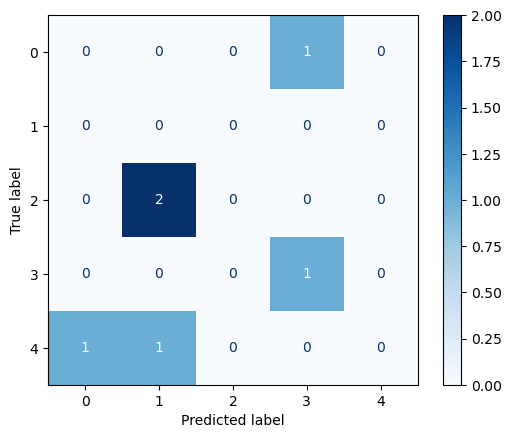

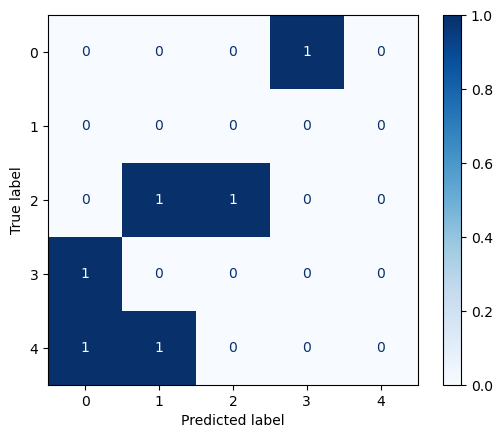

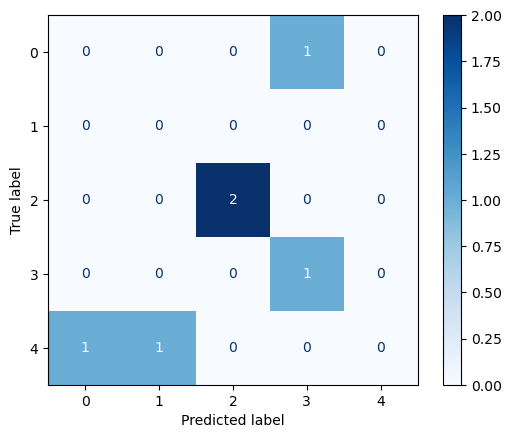

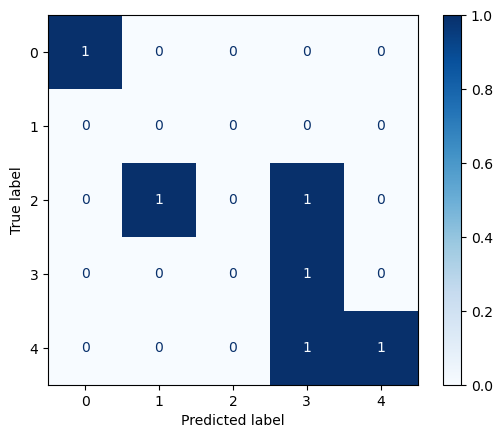

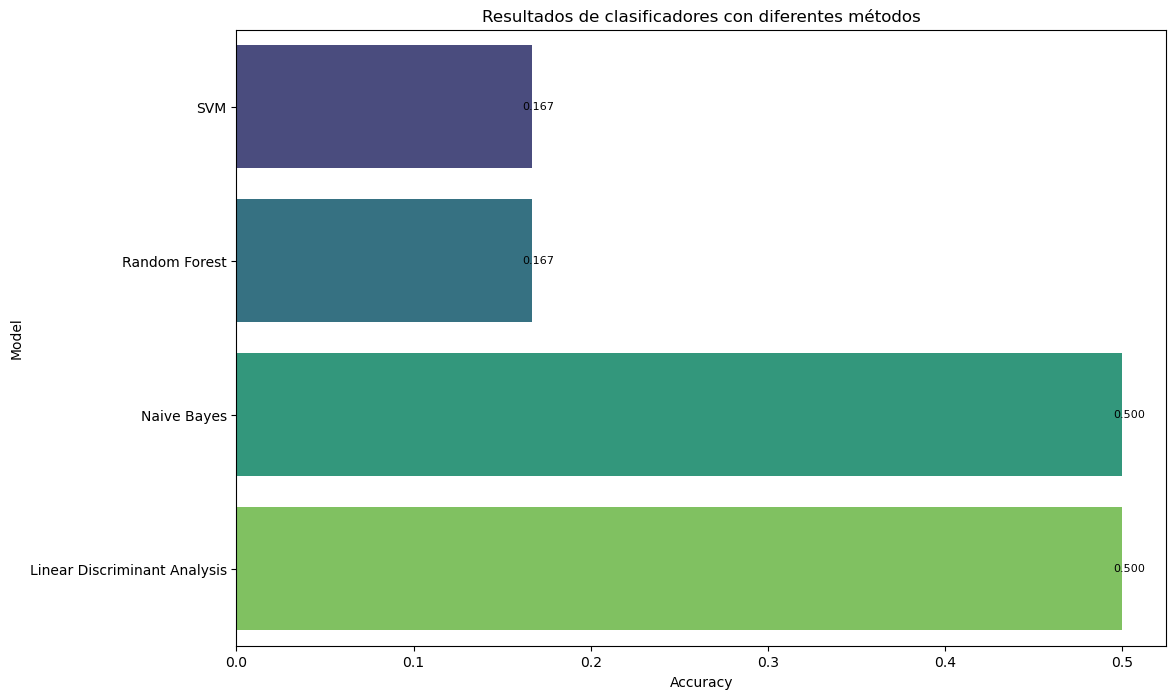

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"Resultados de {model_name}")

    # Entrenar el modelo y realizar predicciones
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)

    # Calcula la matriz de confusión
    conf_matrix = confusion_matrix(y_test, predicted)

    # Visualizar la matriz de confusión con ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)

    # Imprimir un informe de clasificación detallado
    print("Informe de Clasificación:")
    print(classification_report(y_test, predicted))
    print("\n" + "="*50 + "\n")

    # Devolver el accuracy
    accuracy = accuracy_score(y_test, predicted)
    return accuracy

# Cargar el conjunto de datos
data = pd.read_csv("keypoints_videos1_numerico.csv")

# Eliminar la columna "clip_name"
X = data.drop(columns=['clip_name', 'puntos_atencion_visual'])

# Dividir el conjunto de datos en características (X) y etiquetas (y)
y = data['puntos_atencion_visual']

# Convertir etiquetas categóricas a valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir los modelos
models = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis()  # Agregar LinearDiscriminantAnalysis al diccionario
}

# Almacenar resultados de accuracy
results = []

# Evaluación de cada clasificador
for model_name, model in models.items():
    accuracy = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, model_name)
    results.append({'Model': model_name, 'Accuracy': accuracy})

# Crear DataFrame de resultados
results_df = pd.DataFrame(results)

# Crear gráfico de barras con Seaborn
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')

# Añadir etiquetas
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Resultados de clasificadores con diferentes métodos')

# Agregar etiquetas de los valores de Accuracy en cada barra
for p in barplot.patches:
    barplot.annotate(f'{p.get_width():.3f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', fontsize=8, color='black', xytext=(5, 0), textcoords='offset points')

# Mostrar la gráfica
plt.show()


# Selección de características

El código utiliza Bagging junto con LDA como modelo base para seleccionar las características más relevantes y mejorar la capacidad predictiva del modelo en la clasificación. Además, emplea el método SelectKBest, una técnica de ingeniería de características en aprendizaje automático, para identificar las características más significativas, lo que aumenta la precisión y eficiencia del modelo en la tarea de clasificación.

In [30]:
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import SelectFromModel

# Cargar el conjunto de datos
data = pd.read_csv("keypoints_videos1_numerico.csv")

# Eliminar la columna "clip_name"
X = data.drop(columns=['clip_name', 'puntos_atencion_visual'])

# Dividir el conjunto de datos en características (X) y etiquetas (y)
y = data['puntos_atencion_visual']

# Convertir etiquetas de destino a valores numéricos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Entrenar el modelo BaggingClassifier con Linear Discriminant Analysis como base
model_bagging_clf = BaggingClassifier(LinearDiscriminantAnalysis(),
                                      n_estimators=10, random_state=42)
model_bagging_clf.fit(X, y_encoded)

# Obtener el décimo clasificador base
i = 9  # índice 9 para el décimo clasificador (índice 0-based)
est = model_bagging_clf.estimators_samples_[i]

# Seleccionar las características importantes para este clasificador base
sfm_lda_clf = SelectFromModel(model_bagging_clf.estimators_[i], threshold='mean')
sfm_lda_clf.fit(X.iloc[est, :], y_encoded[est])
selected_features_lda_clf = X.columns[sfm_lda_clf.get_support()]

# Imprimir las características seleccionadas para este clasificador base
print("Características Seleccionadas para Linear Discriminant Analysis:")
print(selected_features_lda_clf)


Características Seleccionadas para Linear Discriminant Analysis:
Index(['o_right_y', 'nose_x', 'nose_y', 'mouth_y', 'right_ear_t_y'], dtype='object')


In [31]:
# Importar SelectKBest y chi2
from sklearn.feature_selection import SelectKBest, chi2

# Seleccionar las k mejores características usando la prueba chi-cuadrado
selector = SelectKBest(chi2, k=5)  # Selecciona las 5 mejores características
X_new = selector.fit_transform(X, y)

# Obtener las características seleccionadas
selected_features_indices = selector.get_support(indices=True)
selected_features_nb = X.columns[selected_features_indices]

# Imprimir las características seleccionadas
print("Características Seleccionadas para Naive Bayes (Chi2):")
print(selected_features_nb)

Características Seleccionadas para Naive Bayes (Chi2):
Index(['o_right_x', 'o_left_x', 'nose_x', 'nose_y', 'mouth_x'], dtype='object')


### Evaluación con características de selección de Linear Discriminant Analysis

Resultados de Naive Bayes
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         2
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.30      0.40      0.33         6
weighted avg       0.42      0.50      0.44         6



Resultados de Linear Discriminant Analysis
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2

    accuracy                           0.17         6
   macro

/Users/roxanarachel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/roxanarachel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/roxanarachel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


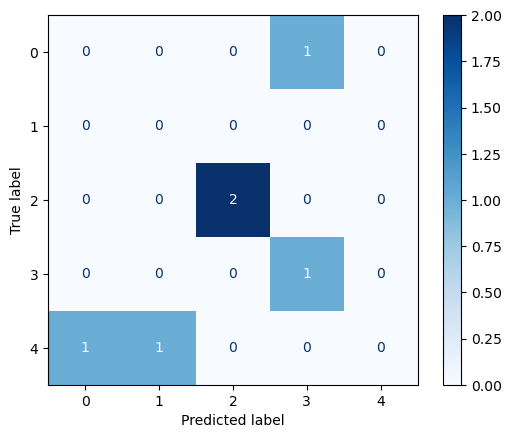

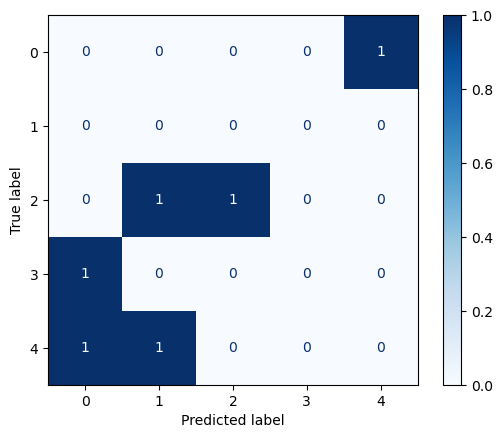

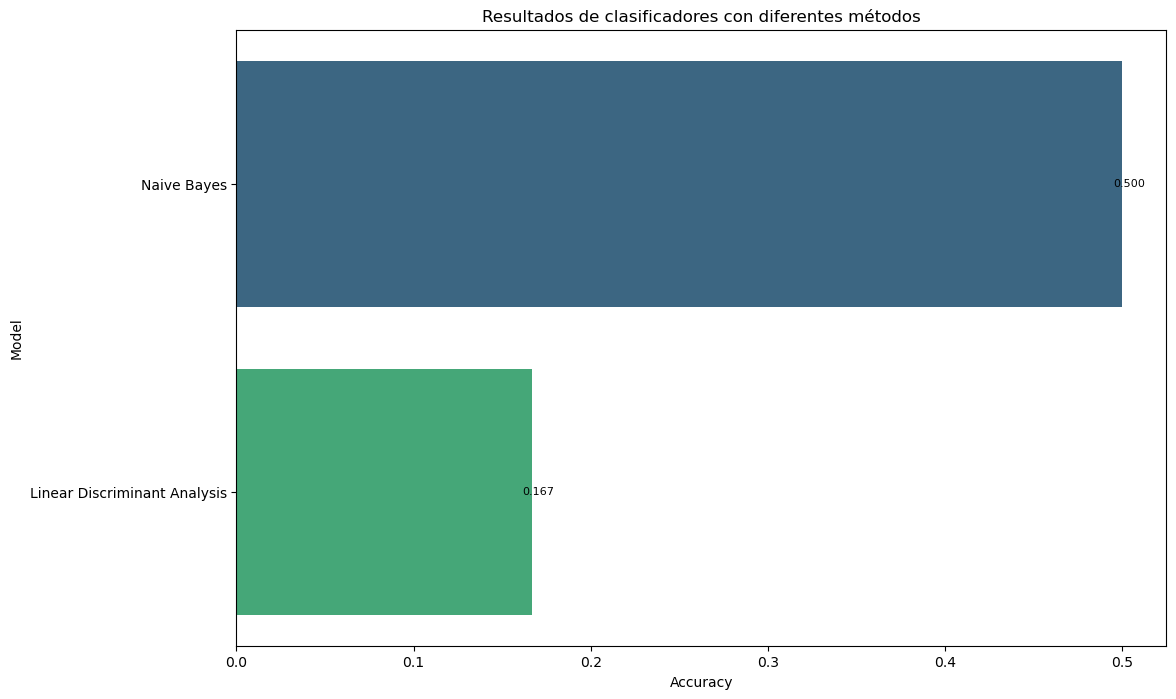

In [43]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"Resultados de {model_name}")

    # Entrenar el modelo y realizar predicciones
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)

    # Calcula la matriz de confusión
    conf_matrix = confusion_matrix(y_test, predicted)

    # Visualizar la matriz de confusión con ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)

    # Imprimir un informe de clasificación detallado
    print("Informe de Clasificación:")
    print(classification_report(y_test, predicted))
    print("\n" + "="*50 + "\n")

    # Devolver el accuracy
    accuracy = accuracy_score(y_test, predicted)
    return accuracy

# Eliminar la columna "clip_name"
X = data.drop(columns=['clip_name', 'puntos_atencion_visual', 'o_right_x', 'o_left_x', 'o_left_y', 'mouth_x', 'right_ear_t_x'
                       , 'left_ear_t_x', 'left_ear_t_y'])

# Dividir el conjunto de datos en características (X) y etiquetas (y)
y = data['puntos_atencion_visual']

# Convertir etiquetas categóricas a valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir los modelos
models = {
    'Naive Bayes': GaussianNB(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis() 
}

# Almacenar resultados de accuracy
results = []

# Evaluación de cada clasificador
for model_name, model in models.items():
    accuracy = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, model_name)
    results.append({'Model': model_name, 'Accuracy': accuracy})

# Crear DataFrame de resultados
results_df = pd.DataFrame(results)

# Crear gráfico de barras con Seaborn
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')

# Añadir etiquetas
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Resultados de clasificadores con diferentes métodos')

# Agregar etiquetas de los valores de Accuracy en cada barra
for p in barplot.patches:
    barplot.annotate(f'{p.get_width():.3f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', fontsize=8, color='black', xytext=(5, 0), textcoords='offset points')

# Mostrar la gráfica
plt.show()


### Características de selección de Naive Bayes

Resultados de Naive Bayes
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         2
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.30      0.40      0.33         6
weighted avg       0.42      0.50      0.44         6



Resultados de Linear Discriminant Analysis
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro

/Users/roxanarachel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/roxanarachel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/roxanarachel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


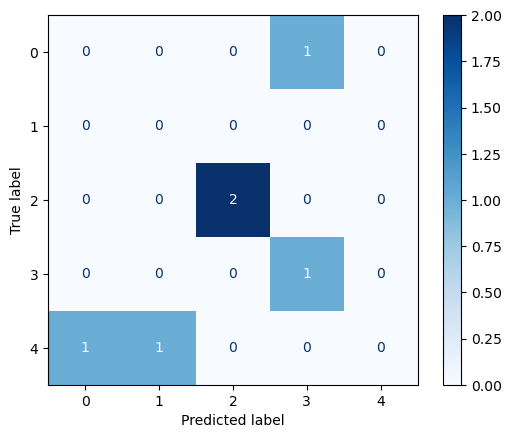

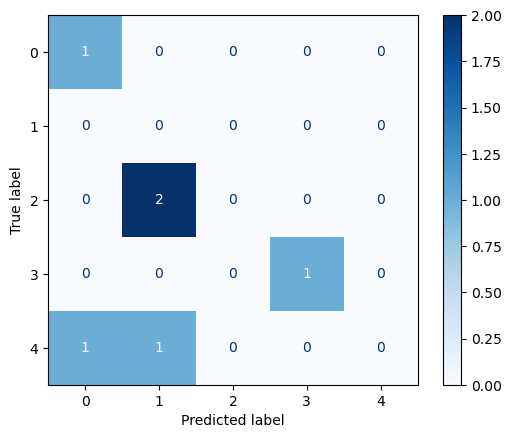

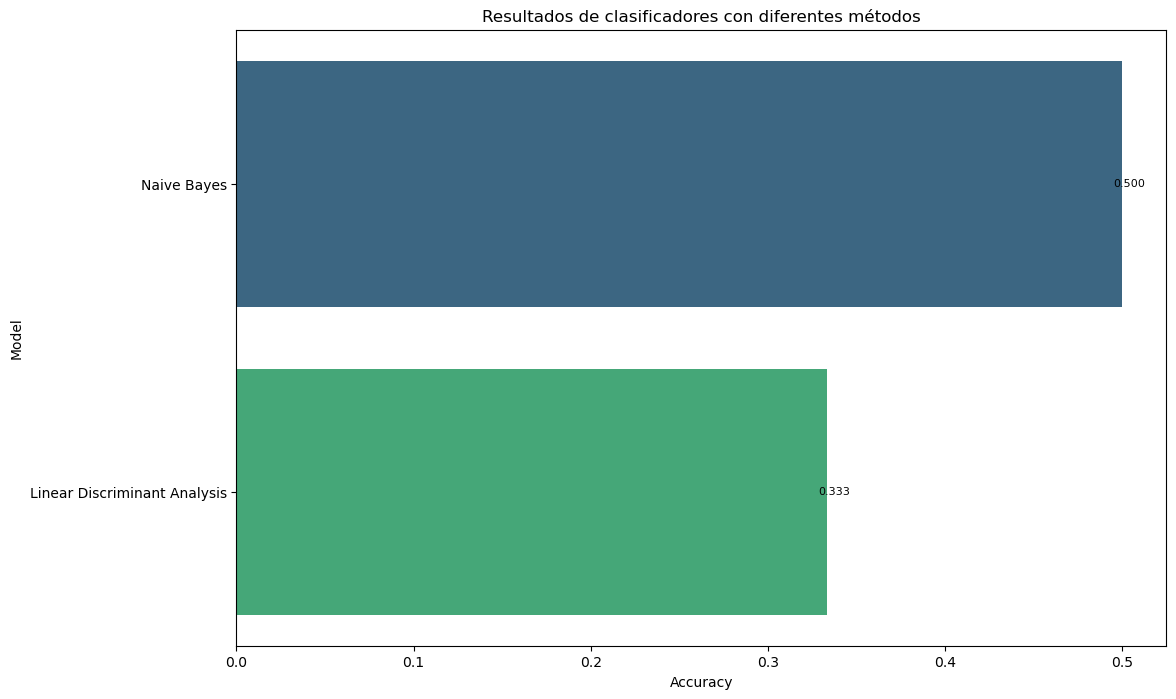

In [33]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"Resultados de {model_name}")

    # Entrenar el modelo y realizar predicciones
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)

    # Calcula la matriz de confusión
    conf_matrix = confusion_matrix(y_test, predicted)

    # Visualizar la matriz de confusión con ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)

    # Imprimir un informe de clasificación detallado
    print("Informe de Clasificación:")
    print(classification_report(y_test, predicted))
    print("\n" + "="*50 + "\n")

    # Devolver el accuracy
    accuracy = accuracy_score(y_test, predicted)
    return accuracy

# Eliminar la columna "clip_name"
X = data.drop(columns=['clip_name', 'puntos_atencion_visual', 'o_right_y', 'o_left_y', 'mouth_y', 'right_ear_t_x', 'right_ear_t_y'
                       ,'left_ear_t_x', 'left_ear_t_y'])

# Dividir el conjunto de datos en características (X) y etiquetas (y)
y = data['puntos_atencion_visual']

# Convertir etiquetas categóricas a valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir los modelos
models = {
    'Naive Bayes': GaussianNB(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis() 
}

# Almacenar resultados de accuracy
results = []

# Evaluación de cada clasificador
for model_name, model in models.items():
    accuracy = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, model_name)
    results.append({'Model': model_name, 'Accuracy': accuracy})

# Crear DataFrame de resultados
results_df = pd.DataFrame(results)

# Crear gráfico de barras con Seaborn
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')

# Añadir etiquetas
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Resultados de clasificadores con diferentes métodos')

# Agregar etiquetas de los valores de Accuracy en cada barra
for p in barplot.patches:
    barplot.annotate(f'{p.get_width():.3f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', fontsize=8, color='black', xytext=(5, 0), textcoords='offset points')

# Mostrar la gráfica
plt.show()


# Tiempo real 

Este código realiza la detección de rostros en tiempo real utilizando la cámara de un dispositivo. Detecta los rostros en cada fotograma capturado, los marca en la imagen y muestra el resultado en una ventana en vivo. Los puntos de atención visual para la detección de rostros se observan en el video en proceso.

In [39]:
import cv2
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils

# Inicializa FaceDetection
face_detection = mp.solutions.face_detection.FaceDetection(
    min_detection_confidence=0.5)

# Iniciar la captura de video desde la cámara
cap = cv2.VideoCapture(0)

while cap.isOpened():
    # Capturar el fotograma de la cámara
    ret, frame = cap.read()
    if not ret:
        break

    # Reflejar horizontalmente la imagen
    frame = cv2.flip(frame, 1)

    # Detección de caras
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image_rgb)

    # Dibujar los resultados en la imagen
    if results.detections:
        for detection in results.detections:
            mp_drawing.draw_detection(frame, detection)

    # Mostrar el fotograma con las detecciones
    cv2.imshow('Face Detection', frame)

    # Esperar la pulsación de la tecla 'Esc' para salir
    if cv2.waitKey(1) & 0xFF == 27:
        break

# Liberar los recursos y cerrar las ventanas
cap.release()
cv2.destroyAllWindows()


I0000 00:00:1707876559.608154       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro
Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1


# Conclusión

En esta práctica, se realizó un exhaustivo proceso de recolección, procesamiento y análisis de datos con el propósito de identificar puntos de atención visual (PAV) en el contexto de la conducción. Los vídeos capturados desde un vehículo se dividieron en clips según los distintos PAV definidos, y en cada clip segmentado se aplicaron técnicas de extracción de keypoints para obtener los puntos correspondientes de las orejas, ojos, boca y nariz, en los ejes (x, y). Luego, se seleccionó una única imagen representativa de cada clip segmentado para una detección precisa del PAV en el individuo.

Posteriormente, se generó un DataFrame que contenía todos los keypoints, así como una columna de clase que representaba los PAV, con el fin de preparar los datos para su análisis mediante modelos de aprendizaje automático. Se construyeron y evaluaron varios modelos de detección de PAV utilizando técnicas como Bagging, Support Vector Machines (SVM), Linear Discriminant Analysis (LDA), Random Forest y Naive Bayes, entre otros. Se observó que Naive Bayes y Linear Discriminant Analysis (LDA) mostraron un desempeño superior al analizar la matriz de confusión en comparación con los demás modelos.

Además, se emplearon técnicas de selección de características para mejorar la capacidad predictiva de los modelos. Se utilizó Bagging en combinación con Linear Discriminant Analysis (LDA), y SelectKBest con chi-cuadrado para Naive Bayes. Se destacó que LDA demostró no requerir una extracción previa de características para ser eficaz, ya que las 12 características originales resultaron fundamentales para su funcionamiento óptimo. En contraste, Naive Bayes pudo operar eficientemente con un subconjunto reducido de características, incluso con solo 5 o 6 de las 12 disponibles, manteniendo un rendimiento comparable al utilizar todas las características.

Los resultados obtenidos respaldaron la viabilidad de emplear técnicas de aprendizaje automático para la detección de PAV en tiempo real, con un enfoque específico en la seguridad vial y la atención del conductor. Se subrayó la importancia de seleccionar adecuadamente el modelo y las características para cada tarea. Además, la relevancia de la segmentación y extracción precisa de características para mejorar la capacidad de los modelos en entornos dinámicos como la conducción. Esta práctica enfatizó la importancia de una recolección de datos adecuada, una segmentación precisa, una selección cuidadosa de modelos y características para mejorar la seguridad y la atención del conductor en situaciones de conducción.